In [ ]:
import numpy as np

# Back-propagation example -- linear regression

In HW1Q5, we derived a closed form solution (i.e. the optimal weights) for linear regression using least squares. In this notebook, we will obtain the optimal weights using gradient descent

## Linear model

Let $\mathbf{X}$ be the matrix of inputs $\mathbf{x} \in \mathbb{R^{D}}$ ($\mathbf{X}$ $\in \mathbb{R^{N \times D}}$), $\mathbf{Y}$ be the matrix of targets $\mathbf{y} \in \mathbb{R^{M}}$ ($\mathbf{Y} \in \mathbb{R^{N \times M}}$) and $\mathbf{W} \in \mathbb{R^{D \times M}}$ be the weight matrix mapping $\mathbf{X}$ to $\mathbf{Y}$ such that,

$\mathrm{\mathbf{Y}} = \mathrm{\mathbf{X}} \mathrm{\mathbf{W}}$

where
$\mathrm{\mathbf{X}} = \begin{bmatrix} \mathbf{x}_1^T \\ \vdots \\ \mathbf{x}_N^T \end{bmatrix}$,
$\mathrm{\mathbf{Y}} = \begin{bmatrix} \mathbf{y}_1^T \\ \vdots \\ \mathbf{y}_N^T \end{bmatrix}$,
$\mathrm{\mathbf{W}} = \begin{bmatrix} \mathbf{w}_1 & \cdots & \mathbf{w}_M \end{bmatrix}$

In [ ]:
# Generate synthetic data

# Data dimensions
N = 1000 # number of data
D = 10   # feature dimension
M = 5    # target dimension
# W has the dimension 10x5

def get_data():
    np.random.seed(0)

    eps = 0.01
    sparsity = 0.5

    W = np.random.randn(D, M)
    mask = np.random.rand(*W.shape) < sparsity
    W[mask] = 0 # make W sparse (contain many zeroes)

    X = np.random.randn(N, D)
    Y = X @ W + eps * np.random.randn(N, M) # add random noise
    return X, Y, W

In [ ]:
X, Y, W_truth = get_data()
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("W shape:", W_truth.shape)

X shape: (1000, 10)
Y shape: (1000, 5)
W shape: (10, 5)


## Loss

- Least squares loss: $l_2 = \dfrac{1}{2}\lVert \mathrm{\mathbf{Y}} - \mathrm{\mathbf{X}} \mathrm{\mathbf{W}} \rVert_F^2$
- L-1 norm regularization: $l_1 = \displaystyle\sum_{i=1}^N \lVert \mathbf{w}_i \rVert_1 = \sum_{i=1}^N \sum_{j=1}^D |w_{ij}|$

- Final loss L = $l_1 + l_2$

Steps for coding backprop:
1. Draw the computational graph
2. Identify individual elements/gates and design forward and backward pass functions for each of them
3. Write the final forward and backward pass function for the entire model, putting the individual elements together in their order of traversal

## Computational graph

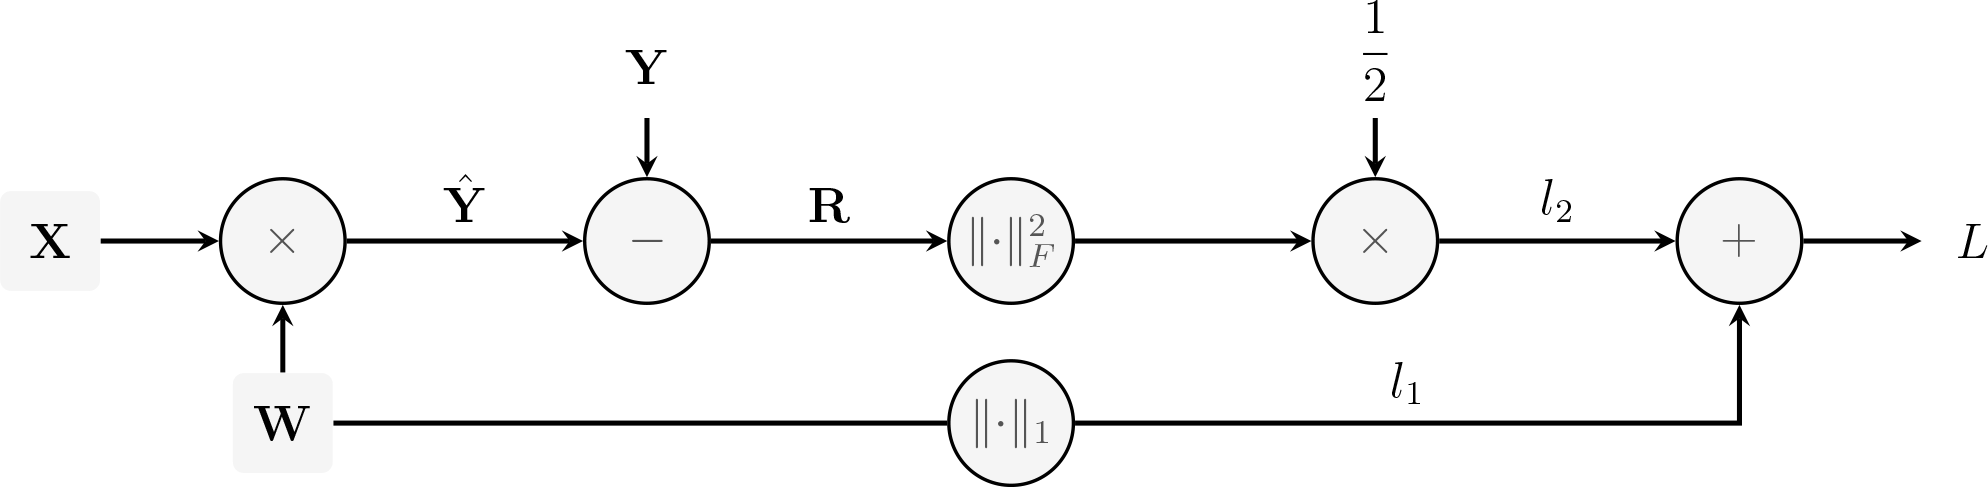

## Derivative by back-propagation

There are five types of units to back propogate through:
1. Addition gate
2. Subtraction gate
3. Multiplication gate
4. Frobenius norm gate
5. L1 norm gate

<hr>

1. Addition gate: If $\mathrm{\mathbf{M}} = \mathrm{\mathbf{A}} + \mathrm{\mathbf{B}}$, then

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{A}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{B}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

In [ ]:
def add_forward(A, B):
    out = A + B
    cache = {}
    return out, cache

def add_backward(dout, cache):
    dA = dout
    dB = dout
    return dA, dB

<hr>

2. Subtraction gate: If $\mathrm{\mathbf{M}} = \mathrm{\mathbf{A}} - \mathrm{\mathbf{B}}$, then

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{A}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{B}}} = -\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

In [ ]:
def minus_forward(A, B):
    out = A - B
    cache = {}
    return out, cache

def minus_backward(dout, cache):
    dA = dout
    dB = -dout
    return dA, dB

<hr>


3. Multiplication gate: If $\mathrm{\mathbf{M}} = \mathrm{\mathbf{A}} \mathrm{\mathbf{B}}$, then

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{A}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} \mathrm{\mathbf{B}}^T$
  
  $\dfrac{\partial L}{\partial \mathrm{\mathbf{B}}} = \mathrm{\mathbf{A}}^T \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

In [ ]:
def mul_forward(A, B):
    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        out = A @ B
    elif isinstance(A, float) and isinstance(B, float):
        out = A * B
    else:
        raise ValueError("Unsupported A and/or B")
    cache = {"A": A, "B": B}
    return out, cache

def mul_backward(dout, cache):
    A, B = cache["A"], cache["B"]
    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        dA = dout @ B.T
        dB = A.T @ dout
    elif isinstance(A, float) and isinstance(B, float):
        dA = dout * B
        dB = dout * A
    else:
        raise ValueError("Unsupported A and/or B")
    return dA, dB

<hr>

4. Frobenius norm gate: If $l = \lVert\mathrm{\mathbf{M}}\rVert_F^2$, then

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} = 2\dfrac{\partial L}{\partial l} \mathrm{\mathbf{M}}$

$
\|\mathbf{A}\|_F = \sqrt{\sum_{i=1}^{m}\sum_{j=1}^{n} |a_{ij}|^2}
$

In [ ]:
def frobenius_norm_square_forward(M):
    cache = {"M": M}
    out = (M ** 2).sum()
    return out, cache

def frobenius_norm_square_backward(dout, cache):
    return 2 * dout * cache["M"]

<hr>

5. L-1 norm gate: $l = \displaystyle \sum_{i=1}^N \sum_{j=1}^D |M_{ij}|$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} = \dfrac{\partial L}{\partial l} \dfrac{\partial l}{\partial \mathrm{\mathbf{M}}}$

  $\left(\dfrac{\partial l}{\partial \mathrm{\mathbf{M}}}\right)_{ij} = \begin{cases} 1 & M_{ij} > 0 \\ -1 & M_{ij} < 0 \\ 0 & \text{otherwise}  \end{cases}$

In [ ]:
A = np.array([[1,1,1],
         [-1,-1,-1],
         [1,1,1]])
print((A+1>0).astype('float'))

[[1. 1. 1.]
 [0. 0. 0.]
 [1. 1. 1.]]


In [ ]:
def l1_norm_forward(M):
    cache = {"M": M}
    out = np.abs(M).sum()
    return out, cache

def l1_norm_backward(dout, cache):
    M = cache["M"]
    dl_dM = (M > 0).astype("float") - (M < 0).astype("float")
    return dout * dl_dM

### Forward pass

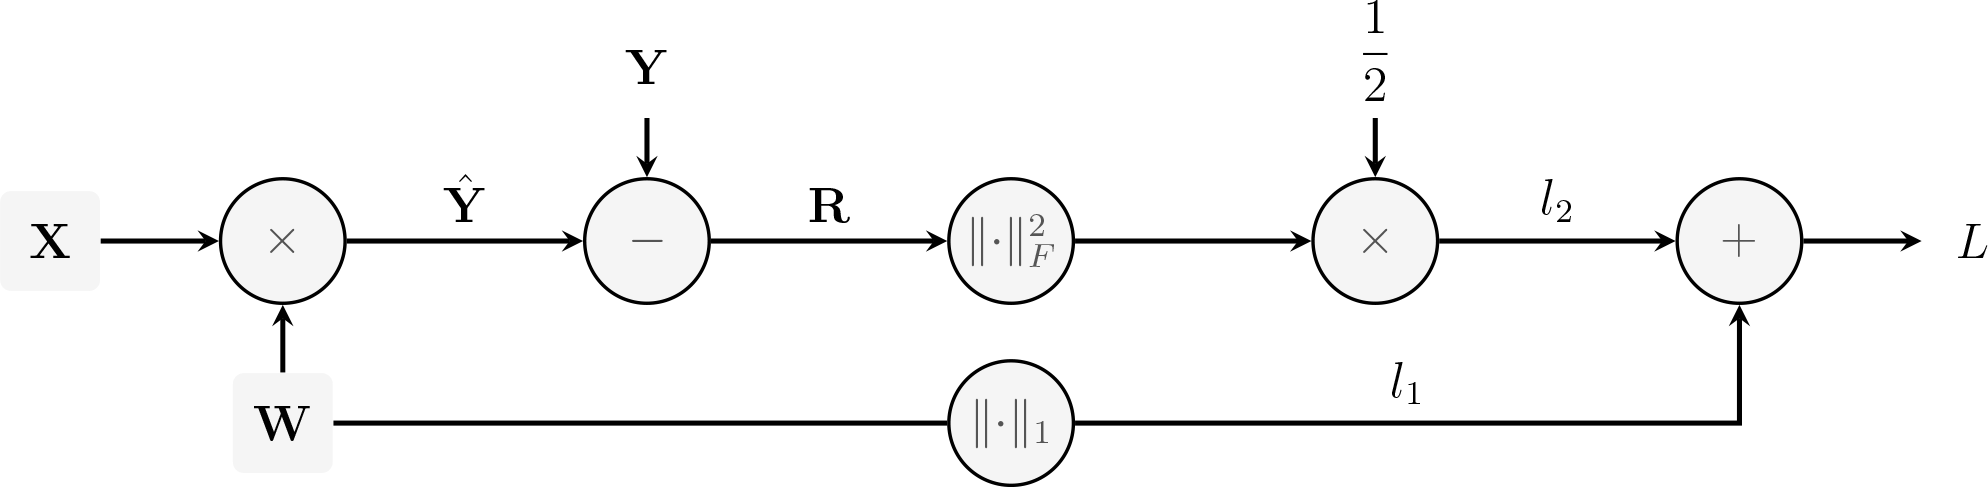

In [ ]:
def forward(W,X,Y):
    Yhat, mul_1_cache = mul_forward(X, W)
    R, minus_cache = minus_forward(Yhat, Y)
    l2_double, fro_cache = frobenius_norm_square_forward(R)
    l2, mul_2_cache = mul_forward(l2_double, 0.5)

    l1, l1_cache = l1_norm_forward(W)

    L, add_cache = add_forward(l1, l2)

    cache = {
        "mul_1_cache": mul_1_cache,
        "minus_cache": minus_cache,
        "fro_cache": fro_cache,
        "mul_2_cache": mul_2_cache,
        "l1_cache": l1_cache,
        "add_cache": add_cache
    }
    return L, cache

### Backward pass

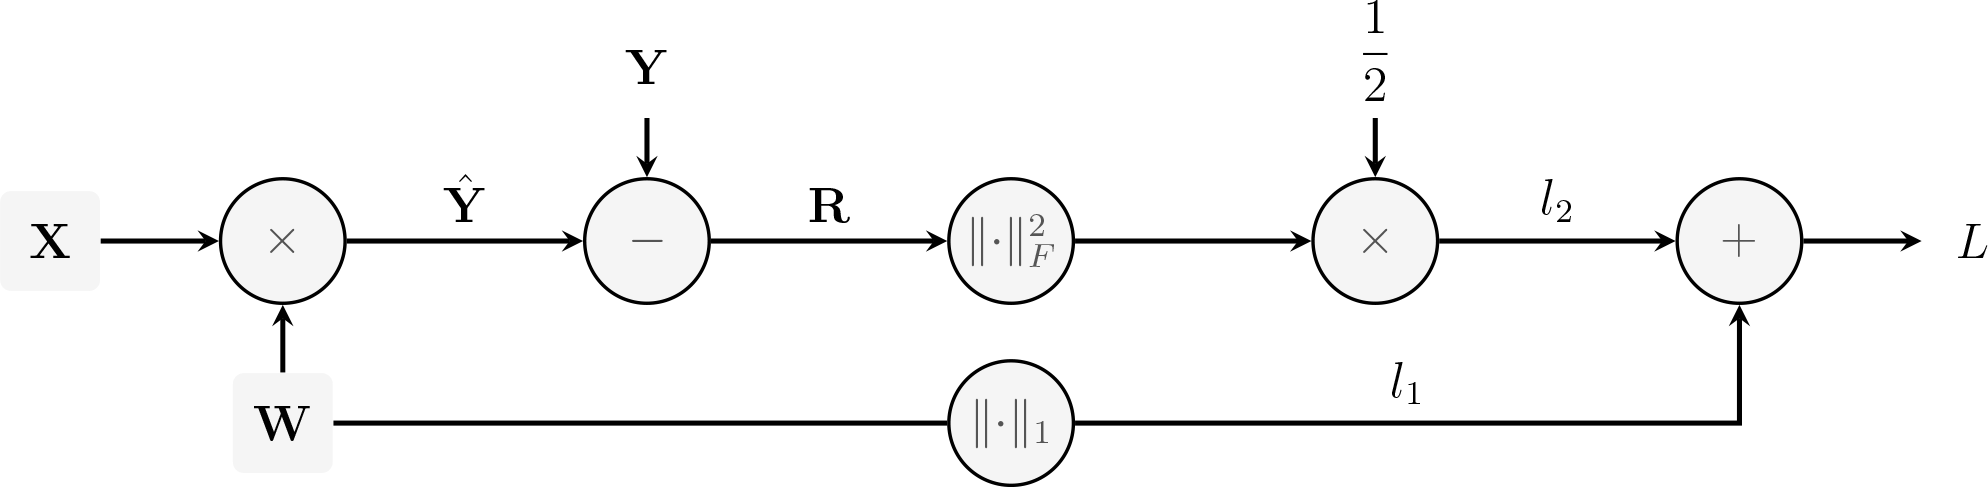

In [ ]:
def backward(cache):
    dL = 1 / N # In class, we assumed dL = 1, here we divide it by N for numerical stability
    dl1, dl2 = add_backward(dL, cache["add_cache"])

    dl2_double, _ = mul_backward(dl2, cache["mul_2_cache"])

    dW_l1 = l1_norm_backward(dl1, cache["l1_cache"])

    dR = frobenius_norm_square_backward(dl2_double, cache["fro_cache"])

    dYhat, dY = minus_backward(dR, cache["minus_cache"])
    dX, dW_l2 = mul_backward(dYhat, cache["mul_1_cache"])

    dW = dW_l1 + dW_l2
    return dW, dX

### Gradient descent

In [ ]:
# randomly initialize the parameters W
W = np.random.randn(*W_truth.shape)

step_size = 0.1
for step in range(100):
    L, cache = forward(W,X,Y)
    dW, dX = backward(cache)
    W += -step_size * dW
    if step % 10 == 0:
        print(L)

36290.385171245536
4493.33068102162
601.1856682872633
100.36237108187048
32.527729728877844
22.858887362068536
21.41741157081782
21.195916267630857
21.16324131701643
21.16090781463644


### Compare with ground truth

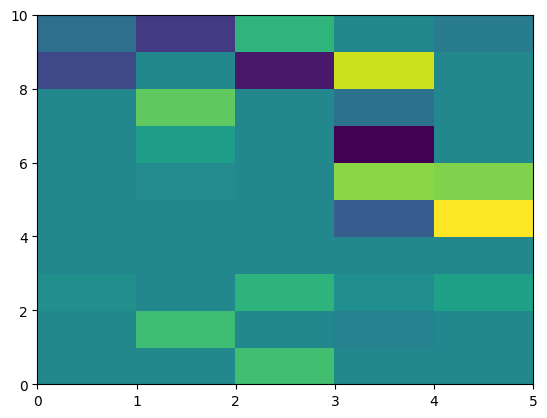

In [ ]:
from matplotlib import pyplot as plt
plt.pcolor(W)

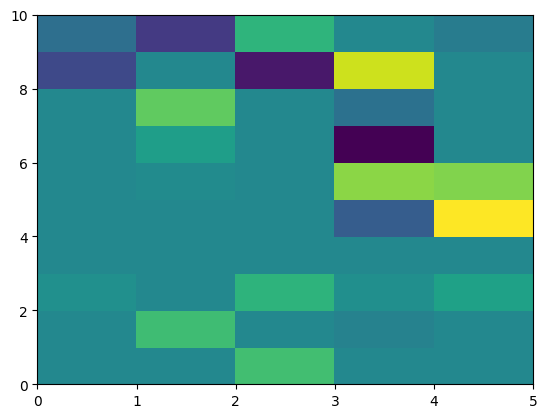

In [ ]:
plt.pcolor(W_truth)

# Derivative when there is broadcasting

```python
N = 100 # number of data points
C = 10 # number of classes
A = np.random.randn(N, C)
b = np.random.randn(C)
# b is broadcasted along rows and added to each row of the matrix A
Z = A + b
```

Suppose we know `dZ` , aka ($\dfrac{\partial L}{\partial \mathrm{\mathbf{Z}}}$), what is `db`, aka ($\dfrac{\partial L}{\partial \mathbf{b}}$)?

- Since its an addition gate `db = dZ`? shape of dz = (N,C) while shape of db should be (C)
- `db = dZ.sum(axis=0)` sum over the axis where the broadcasting happened

In [ ]:
# A note on hyperparameter tuning
# You can tune various knobs of the neural network to improve validation accuracy

#1. If the train and validation errors follow the same trend (i.e. both decreasing steadily), you can increase
#   the learning rate/ number of epochs so as to descend faster / further in the loss curve
#2. If the train error is decresing while validation error increases, the model is probably overfitting and
#.  you might want to tune the regularization parameter/ accordingly. Reducing the batch size also has a regularizing effect.